In [7]:
import json
import pickle
import numpy as np
import pandas as pd
from utils import *

with open("data/results/buckets.pkl", "rb") as f:
    buckets = pickle.load(f)

with open("data/mol_bits.pkl", "rb") as f:
    mol_bits = pickle.load(f)

with open("data/results/test_mols_neighbors.pkl", "rb") as f:
    test_mols_neighbors = pickle.load(f)


train = pd.read_csv("data/activity_train.csv", header=None)
train.columns = ["uniprot_id", "mol_id", "activity"]
train["mol_id"] = train["mol_id"].astype(str).str.strip()

test = pd.read_csv("data/activity_test_blanked.csv", header=None)
test.columns = ["uniprot_id", "mol_id", "activity"]
test["mol_id"] = test["mol_id"].astype(str).str.strip()

train_pivot = train.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).fillna(0)

mol_ids = list(mol_bits.keys())
prot_ids = list(train["uniprot_id"].unique())

# Baseline Estimation for CF
- Define similarity $s_{ij}$ of molecules i and j.
- Select k nearest neighbors N(i;x).
    - Molecules most similar to i, that have activity on protein x.
- Estimate rating $r_{xi}$ as the weighted average:

$$ r_{xi} = b_{xi} + \frac{\sum_{j\in N(i;x)} S_{ij} \cdot (r_{xj} - b_{xj})}{\sum_{j\in N(i;x)} s_{ij}} $$
Where $b_{xi}$ is the baseline estimate for $r_{xi}$:
$$ b_{xi} = \mu + b_x + b_i $$

- $\mu$ - overall mean protein activity
- $b_x$ - activity deviation of molecule x (molecule bias)
- $b_i$ - activity deviation of protein i (protein bias)


## Obtaining $b_{xi}$

In [8]:
def Build_bxi(df):
    mu = df.mean(axis=1).mean()
    bx = df.mean(axis=0) - mu
    bi = df.mean(axis=1) - mu

    bxi = pd.DataFrame(np.full(df.shape, mu), index=df.index, columns=df.columns)
    for i, row in df.iterrows():
        bxi.loc[i] = mu + bx + bi.loc[i]
    return bxi, bx, bi

## Similarities and Nearest Neighbors

- Jaccard similarity - $J(A, B) = \frac{A \cap B}{ A \cup B}$
- Find in each bucket, the top k highest similarity neighbors.


In [9]:
# subsetting for validation

prots = 130
molecules = 67_000

validation_set = (
    train_pivot.iloc[prots:, molecules:]
    .reset_index()
    .melt(id_vars="uniprot_id", value_name="activity")
)
validation_set = validation_set[validation_set["activity"] != 0]
validation_set["activity"] = validation_set["activity"].astype(int)


training_set = (
    train.set_index(["uniprot_id", "mol_id"])
    .drop(validation_set.set_index(["uniprot_id", "mol_id"]).index)
    .reset_index()
)

training_set_pivot = training_set.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).fillna(0)

In [20]:
bxi, bx, bi = Build_bxi(training_set_pivot)
masked_MSE(bxi.values, training_set_pivot.values)

0.5291608603823619

$$ r_{xi} = b_{xi} + \frac{\sum_{j\in N(i;x)} S_{ij} \cdot (r_{xj} - b_{xj})}{\sum_{j\in N(i;x)} s_{ij}} $$


In [21]:
all_test_val_mol_ids = set(test["mol_id"]) | set(validation_set["mol_id"])

In [36]:
def predict_activity(query_mol, prot, training_set, mol_ids, buckets, mol_bits, k):
    neighbors = k_neighbors(
        query_mol, buckets, mol_bits, mol_ids, k=5, test_ids=all_test_val_mol_ids
    )

    neighbor_ids = [mol_ids[neighbors[i][0]] for i in range(len(neighbors))]

    sims_to_calc = []
    activities_to_calc = []
    for i, nei_id in enumerate(neighbor_ids):
        subset = training_set.query(f"mol_id == '{nei_id}' & uniprot_id == '{prot}'")
        if subset.shape[0] > 0:
            sims_to_calc.append(neighbors[i][1])
            activities_to_calc.append(subset["activity"].values[0])
            # print(f"Neighbor {i} has activity")
            # print(subset)
        else:
            # print(f"Neighbor {i} does not have activity")
            continue

    if len(sims_to_calc) == 0:
        return 1
    else:
        activities_to_calc = np.array(activities_to_calc)
        sims_to_calc = np.array(sims_to_calc)
        r = sims_to_calc @ activities_to_calc / sims_to_calc.sum()
    return r.round(0)


val_predicted_activities_5 = []
val_activities_5 = []

for i, row in validation_set.iterrows():
    print(row["mol_id"], row["uniprot_id"])
    predicted = predict_activity(
        mol_ids.index(row["mol_id"]),
        row["uniprot_id"],
        training_set,
        mol_ids,
        buckets,
        mol_bits,
        k=5,
    )
    val_predicted_activities_5.append(predicted)
    val_activities_5.append(row["activity"])
    print("Predicted", predicted)
    print("Real", row["activity"])
    print("----")

CHEMBL560993 Q9Y5Y4
Predicted 7.0
Real 7
----
CHEMBL561007 Q9H244
Predicted 6.0
Real 5
----
CHEMBL561011 Q99705
Predicted 1.0
Real 1
----
CHEMBL561028 Q9Y5N1
Predicted 3.0
Real 7
----
CHEMBL561029 Q9Y5N1
Predicted 1.0
Real 1
----
CHEMBL561085 Q9Y5N1
Predicted 5.0
Real 4
----
CHEMBL561092 Q99705
Predicted 1.0
Real 1
----
CHEMBL561132 Q9Y5Y4
Predicted 7.0
Real 9
----
CHEMBL561148 Q99705
Predicted 3.0
Real 2
----
CHEMBL561228 Q9Y5N1
Predicted 3.0
Real 4
----
CHEMBL561234 Q9Y5N1
Predicted 3.0
Real 2
----
CHEMBL561250 Q9H3N8
Predicted 6.0
Real 6
----
CHEMBL561250 Q9Y5N1
Predicted 7.0
Real 7
----
CHEMBL561279 Q9Y5N1
Predicted 9.0
Real 8
----
CHEMBL561293 Q9Y5N1
Predicted 5.0
Real 6
----
CHEMBL561324 Q9Y5N1
Predicted 9.0
Real 10
----
CHEMBL561355 Q9Y5N1
Predicted 3.0
Real 4
----
CHEMBL561406 Q9H244
Predicted 6.0
Real 6
----
CHEMBL561420 Q9Y5N1
Predicted 5.0
Real 5
----
CHEMBL561433 Q9Y5N1
Predicted 4.0
Real 2
----
CHEMBL561484 Q9H244
Predicted 5.0
Real 5
----
CHEMBL561539 Q9Y5Y4
Predicted 5.0

In [37]:
val_predicted_activities_2 = []
val_activities_2 = []

val_predicted_activities_3 = []
val_activities_3 = []


for i, row in validation_set.iterrows():
    predicted = predict_activity(
        mol_ids.index(row["mol_id"]),
        row["uniprot_id"],
        training_set,
        mol_ids,
        buckets,
        mol_bits,
        k=2,
    )
    val_predicted_activities_2.append(predicted)
    val_activities_2.append(row["activity"])

    predicted = predict_activity(
        mol_ids.index(row["mol_id"]),
        row["uniprot_id"],
        training_set,
        mol_ids,
        buckets,
        mol_bits,
        k=3,
    )

    val_predicted_activities_3.append(predicted)
    val_activities_3.append(row["activity"])

In [38]:
val_predicted_activities_10 = []
val_activities_10 = []


for i, row in validation_set.iterrows():
    predicted = predict_activity(
        mol_ids.index(row["mol_id"]),
        row["uniprot_id"],
        training_set,
        mol_ids,
        buckets,
        mol_bits,
        k=10,
    )
    val_predicted_activities_10.append(predicted)
    val_activities_10.append(row["activity"])

In [39]:
predicted_10 = np.array(val_predicted_activities_10)
real_10 = np.array(val_activities_10)

predicted_5 = np.array(val_predicted_activities_5)
real_5 = np.array(val_activities_5)

predicted_2 = np.array(val_predicted_activities_2)
real_2 = np.array(val_activities_2)

predicted_3 = np.array(val_predicted_activities_3)
real_3 = np.array(val_activities_3)


def rmse(predicted, real):
    return np.sqrt(((predicted - real) ** 2).mean())


print("MSE 10", rmse(predicted_10, real_10))
print("MSE 5", rmse(predicted_5, real_5))
print("MSE 3", rmse(predicted_3, real_3))
print("MSE 2", rmse(predicted_2, real_2))

MSE 10 4.74306651301446
MSE 5 4.74306651301446
MSE 3 4.74306651301446
MSE 2 4.74306651301446


In [45]:
predicted_tosave = []

for row in test.iterrows():
    print(row[1]["mol_id"], row[1]["uniprot_id"])
    predicted = predict_activity(
        mol_ids.index(row[1]["mol_id"]),
        row[1]["uniprot_id"],
        train,
        mol_ids,
        buckets,
        mol_bits,
        k=10,
    )
    predicted_tosave.append(predicted)
    print("Predicted", predicted)
    print("----")

CHEMBL2022258 O14842
Predicted 5.0
----
CHEMBL2047161 O14842
Predicted 5.0
----
CHEMBL2047163 O14842
Predicted 7.0
----
CHEMBL2047168 O14842
Predicted 6.0
----
CHEMBL2047169 O14842
Predicted 6.0
----
CHEMBL2048621 O14842
Predicted 7.0
----
CHEMBL2048623 O14842
Predicted 7.0
----
CHEMBL207881 O14842
Predicted 8.0
----
CHEMBL4067052 O14842
Predicted 2.0
----
CHEMBL4069191 O14842
Predicted 6.0
----
CHEMBL4071899 O14842
Predicted 5.0
----
CHEMBL4787628 O14842
Predicted 5.0
----
CHEMBL4798023 O14842
Predicted 9.0
----
CHEMBL4792075 O14842
Predicted 7.0
----
CHEMBL4787498 O14842
Predicted 7.0
----
CHEMBL81260 P05067
Predicted 6.0
----
CHEMBL55380 P05067
Predicted 9.0
----
CHEMBL78765 P05067
Predicted 3.0
----
CHEMBL76112 P05067
Predicted 10.0
----
CHEMBL58092 P05067
Predicted 1
----
CHEMBL57267 P05067
Predicted 3.0
----
CHEMBL55536 P05067
Predicted 8.0
----
CHEMBL93118 P05067
Predicted 7.0
----
CHEMBL329640 P05067
Predicted 8.0
----
CHEMBL1169460 P05067
Predicted 7.0
----
CHEMBL438972 P05067

In [47]:
test["activity"] = predicted_tosave

In [48]:
test

,uniprot_id,mol_id,activity
0,O14842,CHEMBL2022258,5.0
1,O14842,CHEMBL2047161,5.0
2,O14842,CHEMBL2047163,7.0
3,O14842,CHEMBL2047168,6.0
4,O14842,CHEMBL2047169,6.0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,8.0
4624,Q9Y5Y4,CHEMBL4205421,4.0
4625,Q9Y5Y4,CHEMBL4207935,8.0
4626,Q9Y5Y4,CHEMBL4208884,6.0


In [54]:
test.to_csv("data/results/preds_05.csv")

<Axes: ylabel='Frequency'>

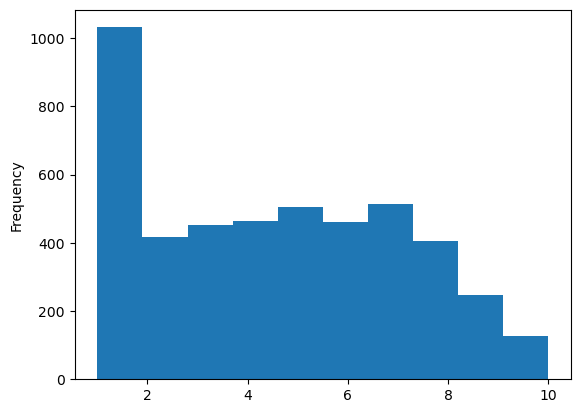

In [51]:
test["activity"].plot.hist()

<Axes: ylabel='Frequency'>

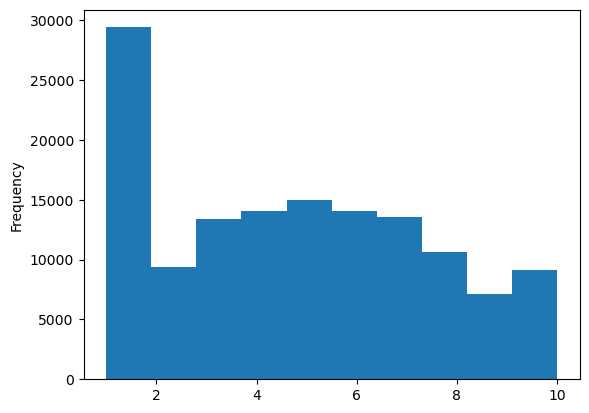

In [53]:
train["activity"].plot.hist()